In [1]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import warnings
import sympy
sympy.init_printing()

notes for intro to numerical methods

reference: https://github.com/mandli/intro-numerical-methods

# ODE Initial Value Problems

Problem statement:

$$
  \frac{du}{dt} = f(t, u) ~~~u(0) = u_0
$$

We know the initial value of the vector $u$ and its derivative with respect to $t$. 

### discretization
We can approximate the derivative numerically, ie.

$$\frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u).$$



## forward scheme:
Let $U_n$ be the approximated value of $u(t + \Delta t)$ at $n$-th time steps, the forward Euler method can be written as 
$$
\frac{U_{n+1} - U_{n}}{\Delta t} = f(t_n, U_n),
$$
or
$$U_{n+1} = U_{n} + \Delta t f(t_n, U_n).$$

Foward Euler is a first order accurate and consistent method. It's truncation error, difference between true solution and numerically approximated solution, can be calculated using the Taylor expansion of $u(t)$ centered at $t_n$ and evaluated at $t_{n+1}$. 


## central scheme:
Alternatively, we could use the second order central difference then take the integral. The leap-frog method is 
$$
\frac{U_{n+1} - U_{n-1}}{2\Delta t} = f(t_n, U_n).
$$

Following a similar analysis, the leap-frog method is second order accurate and we need to use a higher order of Taylor series. 

## backward scheme:
Similar to forward Euler method, backward Euler is an implicit method that evaluates the function at a later time. It can be written as
$$
U_{n+1} = U_{n} + \Delta t f(t_{n+1}, U_{n+1}).
$$


## trapezoidal:
Based on the trapezoidal rule, we have another scheme
$$
\frac{U_{n+1} - U_{n}}{\Delta t} = \frac 1 2 (f(U_n) - f(U_{n+1}))
$$

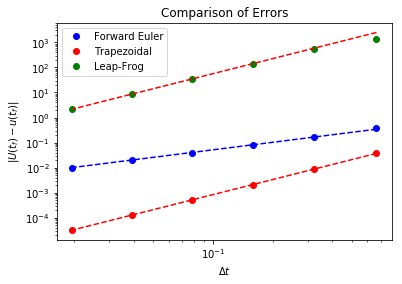

In [5]:
## u' = -u
## true solution is u = e^(-t)
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))
error_leapfrog = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = u_0
    for n in range(t.shape[0] - 1):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t[n], u_euler[n])
        
    # Compute trapezoidal
    u_trap = numpy.empty(t.shape)
    u_trap[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(t.shape[0] - 1):
        u_trap[n + 1] = u_trap[n] * integration_constant
        
    # Compute Leap-Frog
    u_leapfrog = numpy.empty(t.shape)
    u_leapfrog[0] = 1.0
    u_leapfrog[1] = u_euler[1]
    for n in range(1, t.shape[0] - 1):
        u_leapfrog[n+1] = u_leapfrog[n-1] + 2.0 * delta_t[i] * f(t[n], u_leapfrog[n])
        
    # Compute error for each
    error_euler[i] = numpy.linalg.norm(delta_t[i] * (u_euler - u_exact(t)), ord=1)
    error_trap[i] = numpy.linalg.norm(delta_t[i] * (u_trap - u_exact(t)), ord=1)
    error_leapfrog[i] = numpy.linalg.norm(delta_t[i] * (u_leapfrog - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_trap, 'ro', label='Trapezoidal')
axes.loglog(delta_t, error_leapfrog, 'go', label="Leap-Frog")

## plot second order and first order convergence
axes.loglog(delta_t, order_C(delta_t[2], error_euler[2], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[2], error_trap[2], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[2], error_leapfrog[2], 2.0) * delta_t**2.0, '--r')

axes.legend(loc=2)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

## Taylor Series Method:

For general taylor expansion we have
$$
u(t_{n+1}) = u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) + \frac{\Delta t^3}{6}u'''(t_n) + \cdots.
$$
We can replace the dirivatives of $u$ with the derivatives of $f$ based on the original ODE. Since the order of $f$ will be one less than the order of $u$, the method can be rewritten as
$$
u(t_{n+1}) = u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) + \frac{\Delta t^3}{6}f''(t_n, u(t_n)) + \cdots
$$

### 2nd Order Taylor Series Methods:

For example, if we want a second order method, we need to differentiate $f$ once again,
$$
U_{n+1} = U_n + \Delta t f(t_n, U_n) + \frac{\Delta t^2}{2} f'(t_n, U_n).
$$

## Runge-Kutta Methods:

The order of accuracy can be increased by adding intermediate stages in the schemes. Evaluating at $t_n + \Delta t/2$ will give a second order Runge-Kutta method. 

### 2nd Order Runge-Kutta:
$$
\begin{align}
U^* &= U^n + \frac 1 2 \Delta t f(U^n)\\
U^{n+1} &= U^n + \Delta t f(U^*)\\
        &= U^n + \Delta t (U^n + \frac 1 2 \Delta t f(U^n))
\end{align}
$$

### 4th Order Runge-Kutta:
$$
\begin{align}
Y_1 &= U_n\\
Y_2 &= U_n + \frac 1 2 \Delta t f(Y_1, t_n)\\
Y_3 &= U_n + \frac 1 2 \Delta t f(Y_2, t_n + \Delta t/2)\\
Y_4 &= U_n + \Delta t f(Y_3, t_n + \Delta t/2)\\
U_{n+1} &= U_n = \frac{\Delta t}{6}[f(Y_1, t_n) + 2 f(Y_2, t_n + \Delta t/2) + 2 f(Y_3, t_n + \Delta t/2) + f(Y_4, t_n + \Delta t)]
\end{align}
$$

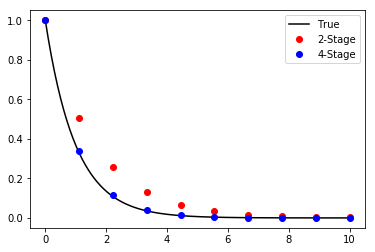

In [6]:
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 10
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_2 = numpy.empty(t.shape)
u_4 = numpy.empty(t.shape)
u_2[0] = 1.0
u_4[0] = 1.0

for (n, t_n) in enumerate(t[1:]):
    u_2[n+1] = u_2[n] + 0.5 * delta_t * f(t_n, u_2[n])
    u_2[n+1] = u_2[n] + delta_t * f(t_n, u_2[n+1])
    y_1 = u_4[n]
    y_2 = u_4[n] + 0.5 * delta_t * f(t_n, y_1)
    y_3 = u_4[n] + 0.5 * delta_t * f(t_n + 0.5 * delta_t, y_2)
    y_4 = u_4[n] + delta_t * f(t_n + 0.5 * delta_t, y_3)
    u_4[n+1] = u_4[n] + delta_t / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t, y_2) + 2.0 * f(t_n + 0.5 * delta_t, y_3) + f(t_n + delta_t, y_4))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_2, 'ro', label="2-Stage")
axes.plot(t, u_4, 'bo', label="4-Stage")
axes.legend(loc=1)

plt.show()

## Linear Multi-Step Methods

We could use multiple time steps to evaluate the approximation; it is easier to implement than Taylor series expansion and it does not need to evaluate the function multiple times as higher order one-step methods do. However, the method is not self-starting. 

### General Linear Multi-Step
The method can be written as a linear combination of other solutions:
$$
\sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0}\beta_j f(U_{n+j}, t_{n+j}).
$$

The method is implicit if $\beta_r=0$, which means that it only requires previous timestep. 

### Adams Methods

$$
U_{n+r} = U_{n+r-1} + \Delta t \sum^r_{j=0}\beta_j U_{n+j}.
$$

### Adams-Bashforth
Adams-Bashforth are explicit methods that maximizes the order of accuracy using the coefficients that will eliminate as many terms in the Taylor expansion as possible. Below are four steps Adams-Bashforth methods; we could use a two step Runge-Kutta to start the method if we would like to use two step AB.
$$
\begin{align}
U_{n+1} &= U_n + \Delta t f(U_n)\\
U_{n+2} &= U_{n+1} + \frac{\Delta t}{2}(-f(U_n) + 3f(U_{n+1}))\\
U_{n+3} &= U_{n+2} + \frac{\Delta t}{12}(5f(U_n) - 16f(U_{n+1}) + 23 f(U_{n+2}))\\
U_{n+4} &= U_{n+3} + \frac{\Delta t}{24}(-9f(U_n) + 37f(U_{n+1}) - 59f(U_{n+2}) + 55f(U_{n+3}))
\end{align}
$$

### Adams-Moulton 
Adams-Moulton ethods are implicit solvers of Adams-Bashforth methods:
$$
\begin{align}
U_{n+1} &= U_{n} + \frac{\Delta t}{2}(f(U_n) + f(U_{n+1}))\\
U_{n+2} &= U_{n+1} + \frac{\Delta t}{12}(-f(U_n) + 8f(U_{n+1}) + 5 f(U_{n+2}))\\
U_{n+3} &= U_{n+2} + \frac{\Delta t}{24}(f(U_n) -5 f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3}))\\
U_{n+4} &= U_{n+3} + \frac{\Delta t}{720}(-19f(U_n) + 106 f(U_{n+1}) - 264 f(U_{n+2}) + 646f(U_{n+3}) + 251f(U_{n+4}))
\end{align}
$$



## Predictor-Corrector Methods

We can estimate the implicit function with the explicit method to skip the implicit evaluations in the Adams-Moulton methods.

### One-Step Adams-Bashforth-Moulton 
The updating scheme of using AB to predict the value of $U_{n+1}$ then using AM to correct is expressed as 
$$
\begin{align}
\hat{U}_{n+1} &= U_n + \Delta t f(U_n)\\
U_{n+1} &= U_n + \frac 1 2 \Delta t (f(U_n) + f(\hat{U}_{n+1}))
\end{align}
$$